# BO initialization

#### Part 1
This Notebook constitue the first step of this project, initial tries with the Morgan fingerprint and defaults BayBE settings. At first, we were working with the non-sanitized catalyst 2, this is why we used those [CustomDiscreteParameter](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.parameters.custom.CustomDiscreteParameter.html#baybe.parameters.custom.CustomDiscreteParameter) instead of the [SubstanceParameter](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.parameters.substance.SubstanceParameter.html#baybe.parameters.substance.SubstanceParameter) included in BayBE, which [allows direct and simplified fingerprinting](https://emdgroup.github.io/baybe/stable/index.html). Using the CustomDiscreteParameter allowed us to skip the sanitization, since we built our own fingerprinting logic. This notebook investigate the effect of the initialization sequence, especially the differences between choosing points at random (uniform) vs at farthest (farthest point sampling). It also looks in details the default behavior of BayBE and its limitations.

**BayBE defaults:** 

Surrogate: [Gaussian Process](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.surrogates.html) (default of [Botorch Recommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.bayesian.botorch.html#module-baybe.recommenders.pure.bayesian.botorch))

Acquisition function: [qLogExpectedImprovement](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.acquisition.acqfs.html#module-baybe.acquisition.acqfs), descibed as Logarithmic Monte Carlo based expected improvement.

#### Part 2
In a second part, this Notebook investigate the effect of the [surrogate model](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.surrogates.html)

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import getMolFromSmile, SmilesToDescriptors, plot_results

c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load the dataset, if not available run process_database.py first

df = pd.read_csv('dataset.csv')
df.head(2)

,reactant_1,reactant_2,reactant_3,product_R,product_S,solvent,catalyst_1,catalyst_2,product_undesired_R,product_undesired_S,ee_R,ee_S,ee_undesired_R,ee_undesired_S,yield_undesired_R,yield_undesired_S,reaction,curated_catalyst_2
0,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,0.63,-0.63,0.0,0.0,0.095598,0.094402,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C1COCCN1.F[P](F)...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...
1,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,44.66,-44.66,0.0,0.0,0.412281,0.157719,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C[Si](C)(C)OC(c1...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...


In [3]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['catalyst_2'].unique()

#### Compute the descriptors

In [4]:
#Computing the Morgan descriptors for the reactants and catalysts, Morgan radius = 2, bit vector length = 1024

reactant_1_descriptors = SmilesToDescriptors(reactant_1_pool, method='Morgan')
catalyst_1_descriptors = SmilesToDescriptors(catalyst_1_pool, method='Morgan')
catalyst_2_descriptors = SmilesToDescriptors(catalyst_2_pool, method='Morgan', sanitize=False)

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,...,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Build the searchspace and define target objective

In [5]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace
from baybe.utils.random import set_random_seed

set_random_seed(11)

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)

target = NumericalTarget(
    name="ee_R",
    mode="MAX",
)

objective = SingleTargetObjective(target=target)

"""
The lookup is what BayBE use to retrieve to retrieve the ee of a given reaction within the simulation framework.
Since our substance parameters are indexed by the SMILE, we can provide the lookup table with the SMILES. 
In the end, any label can be used for that as long as the parameters indexes match the what is in the lookup table.
The columns name should match the parameters names, as well as the target name.
"""

lookup = df[['reactant_1', 'catalyst_1', 'catalyst_2', 'ee_R']]
lookup.head(2)

,reactant_1,catalyst_1,catalyst_2,ee_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,0.63
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,44.66


#### Defining the optimizer, creating campaigns and defining scenario

The [TwoPhaseMetaRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender.html#baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender) provide a conveniant way of starting with one sampling method, followed by an optimization sequence, starting after n iterations, set in the `switch_after = n` parameter.

The ``Scenario`` contains all the campaigns that we want to run. This [guide](https://emdgroup.github.io/baybe/stable/userguide/simulation.html) provide additional examples.

In [6]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1              #Nbr of recommendations per iteration
N_DOE_ITERATIONS = 100      #Nbr of total iterations
N_MC_ITERATIONS = 5         #Nbr of Monte Carlo iterations (parallel experiments to provide SD)

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),               # farthest point sampling
    recommender=BotorchRecommender(),                   # Bayesian optimization
    switch_after=10,                                    # switch to Bayesian after 10 iterations
    )

botorch_rdm_recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),            # random point sampling (uniform)
    recommender=BotorchRecommender(),                   # Bayesian optimization
    switch_after=10,                                    # switch to Bayesian after 10 iterations
    )

botorch_recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),            # random point sampling (uniform)
    recommender=BotorchRecommender(),                   # Bayesian optimization
    switch_after=1,                                     # switch immediately (No initialization phase)
    )

fps_recommender = FPSRecommender()                      # Baseline recommender using farthest point sampling
random_recommender = RandomRecommender()                # Baseline recommender using random point sampling (uniform)

#The campaign specifies the search space, the objective, and the recommender to use.
botorch_fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)
botorch_rdm_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_rdm_recommender)

#botorch_fps_rdm_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_rdm_recommender)

botorch_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_recommender)

fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=fps_recommender)
random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

#The scenarios contains all the campaigns that we want to try.
scenarios = {"GP FPS": botorch_fps_campaign,"GP rdm": botorch_rdm_campaign, "GP":botorch_campaign, "Random": random_campaign, "FPS": fps_campaign}

In [7]:
#simulate the scenarios, takes around 12 minutes on my laptop (11th Gen i7 @ 2.80 GHz, 16GB RAM)
results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-pack

Note the numerical warnings, they may be responsible for small trajectories differences in GP FPS

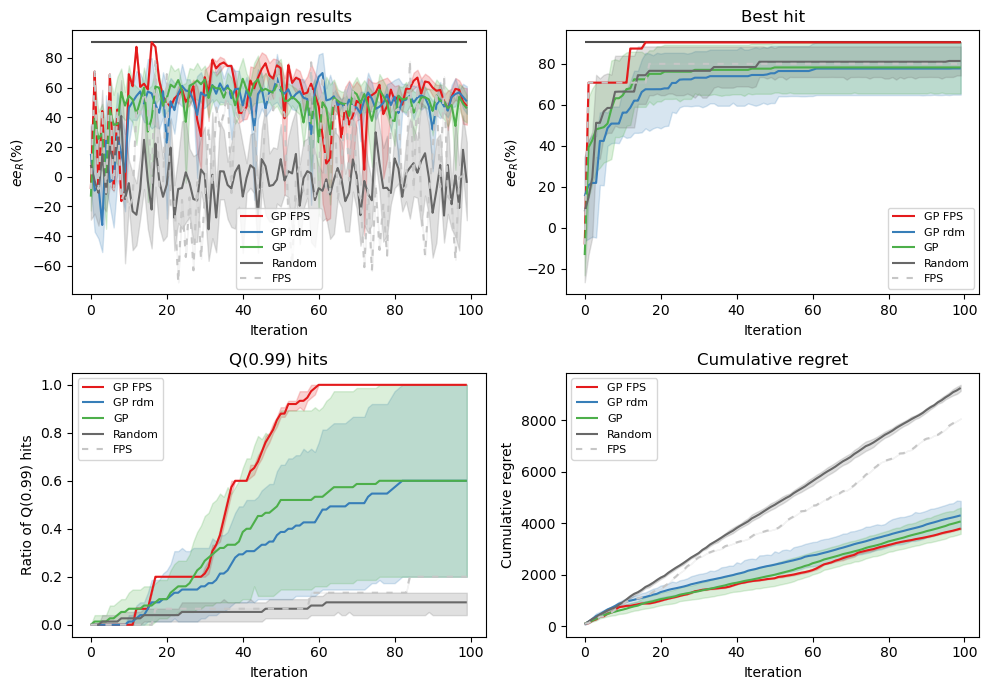

In [8]:
plot_results(results, lookup, figure_name= 'init_bo.png', nbr_controls=2)

In [9]:
results

,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,ee_R_Measurements,ee_R_IterBest,ee_R_CumBest,ins_regret,sim_regret,cum_regret,top_hits
0,GP FPS,0,0,1,[-8.270000457763672],-8.270000,-8.270000,98.719997,98.719997,98.719997,0.0
1,GP FPS,0,1,2,[70.7699966430664],70.769997,70.769997,19.680000,19.680000,118.399998,0.0
2,GP FPS,0,2,3,[-8.460000038146973],-8.460000,70.769997,98.909997,19.680000,217.309995,0.0
3,GP FPS,0,3,4,[44.22999954223633],44.230000,70.769997,46.219997,19.680000,263.529992,0.0
4,GP FPS,0,4,5,[-10.670000076293944],-10.670000,70.769997,101.119997,19.680000,364.649989,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2495,FPS,4,95,96,[-16.850000381469727],-16.850000,79.949997,107.299997,10.500000,7654.339723,0.2
2496,FPS,4,96,97,[-55.7599983215332],-55.759998,79.949997,146.209995,10.500000,7800.549718,0.2
2497,FPS,4,97,98,[-0.4199999868869781],-0.420000,79.949997,90.869997,10.500000,7891.419715,0.2
2498,FPS,4,98,99,[0.4399999976158142],0.440000,79.949997,90.009997,10.500000,7981.429712,0.2


#### More in depth evaluation of the initialization

This part came after the realisation that the FPS method was deterministic, indeed the initialization sequence was always exactly the same, which prevented a proper evaluation of the effect of the first experiment done. Combining two TwoPhaseMetaRecommender (one that sample uniform the first point then switch to FPS, embedded into another that switch to Botorch) was found to be an unsuccessful strategy. The first point was properly selected at random, but the rest of the sequence was identical and the effect on the overall trajectory was thus rather limited. This highlighted the [strange behavior of FPS](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.utils.sampling_algorithms.farthest_point_sampling.html):

``farthest_point_sampling(data, n_samples=int, initialization='farthest')`` indeed sequentially (for n_samples) samples farthest points based on euclidian distances, starting either at *farthest* or *uniform*. This initial *farthest* is what lead to this deterministic sequence, because it sample the *farthest* point in the dataset (or remaining unexplored points) at each iteration, not relatively to previously sampled points (when BATCH_SIZE = 1, n_samples = 1). If undesrstood properly, the algorithm compute the pairwise distance between all the points in the space, then recover the one with the largest distance to another one. As shown below, sampling a whole sequence with (n_samples=int) cover properly the reaction space, while sampling iteratively with (n_samples=1) lead to points being less spread in the chemical space. This last behavior is the default when using the FPSRecommender, and could be improved in BayBE.


**Plotting the initialization sequence in projected reaction space**

c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\gagne\miniconda3\envs\ai4chem\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:

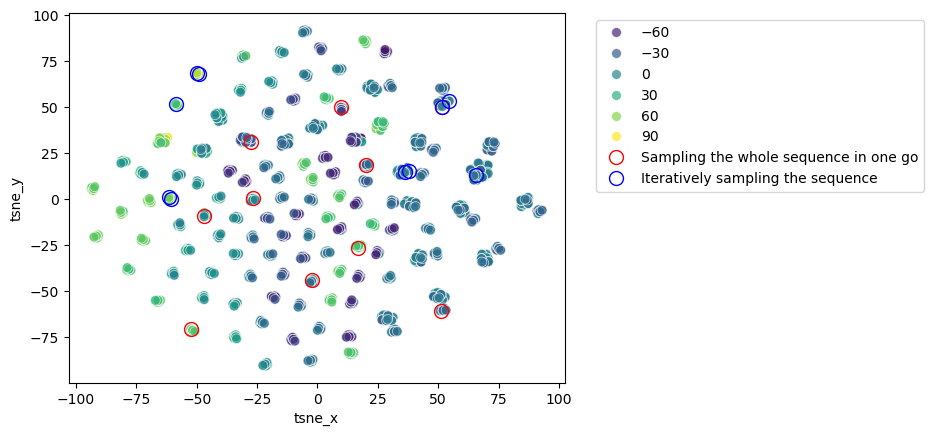

In [10]:
#to run this cell, previous cell defining the searchspace and campaigns should be run first

from baybe.utils.sampling_algorithms import farthest_point_sampling
from baybe.simulation.lookup import look_up_targets
from sklearn.manifold import TSNE
import seaborn as sns

set_random_seed(11)

cp = searchspace.discrete.comp_rep.to_numpy()
v = cp.copy()

exrep = searchspace.discrete.exp_rep.copy()

#Sampling the whole sequence with the algorithm, each point is sampled far from the previous one.
seq = farthest_point_sampling(cp, n_samples = 10, initialization='farthest')

#Sampling the sequence iteratively, with initialization to farthest. Each point sampled correspond to the one farthest from another one in the remaining
#unexplored points.
it = []
for i in range(10):
  s=farthest_point_sampling(cp, n_samples = 1, initialization='farthest')[0]
  it.append(int(s))
  cp = np.delete(cp, s, axis=0)

#Add the ee_R values to the experimental representation
look_up_targets(exrep, botorch_campaign.targets, lookup, "error")

#Compute the tSNE projection of the reaction space (computed representation), experimental and computed representation are aligned.
tsne = TSNE(n_components=2, random_state=42, perplexity=7)
v_tsne = tsne.fit_transform(v)

exrep['tsne_x'] = v_tsne[:, 0]
exrep['tsne_y'] = v_tsne[:, 1]

#Get the coordinates of the sampled points in the tSNE projection
seq_coord = v_tsne[seq]
it_coord = v_tsne[it]

#Plot
ax = sns.scatterplot(
    data=exrep,
    x='tsne_x',
    y='tsne_y',
    hue='ee_R',
    palette='viridis',
    alpha=0.7,
    s=50,
)

plt.plot(seq_coord[:, 0], seq_coord[:, 1], 'o', markersize=10, color='red', label='Sampling the whole sequence in one go', markerfacecolor='none')
plt.plot(it_coord[:, 0], it_coord[:, 1], 'o', markersize=10, color='blue', label='Iteratively sampling the sequence', markerfacecolor='none')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('./figures/fps.png', bbox_inches='tight', dpi=300)
plt.show()

#### Running the simulations with redefined initialization sequence to properly sample the space

The first point in `GP FPS det` is sampled using the `initialization = farthest`, leading to a deterministic sequence but properly sampled.

In `GP FPS uniform`, the first point is uniformly sampled and followed by a properly computed farthest point sequence.

Finally, `GP uniform` are uniformly sampled, and `GP FPS default` mimic the default behaviour, where samples are sampled relative to the unexplored points, not the explored ones.

In [11]:
#simulate the scenarios, takes around 20 minutes on my laptop (11th Gen i7 @ 2.80 GHz, 16GB RAM)
from baybe.simulation.lookup import look_up_targets

set_random_seed(11)

N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5
BATCH_SIZE = 1

N_INITIALIZATION = 10       # Number of initial points to sample for each campaign

botorch_recommender = BotorchRecommender()

# Create campaigns for different initialization strategies, with MC runs
campaigns_uniform = [Campaign(searchspace=searchspace, objective=objective, recommender=botorch_recommender) for _ in range(N_MC_ITERATIONS)]
campaigns_det = [Campaign(searchspace=searchspace, objective=objective, recommender=botorch_recommender) for _ in range(N_MC_ITERATIONS)]
campaigns_def = [Campaign(searchspace=searchspace, objective=objective, recommender=botorch_recommender) for _ in range(N_MC_ITERATIONS)]
campaigns_non_det = [Campaign(searchspace=searchspace, objective=objective, recommender=botorch_recommender) for _ in range(N_MC_ITERATIONS)]
random = [Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender) for _ in range(N_MC_ITERATIONS)]

# Initialize the campaigns with the first points

#Uniformely
for camp in campaigns_uniform:
  x = camp.searchspace.discrete.comp_rep.to_numpy()
  indices = np.random.choice(x.shape[0], size=N_INITIALIZATION, replace=False)
  exprep=camp.searchspace.discrete.exp_rep.iloc[indices]
  look_up_targets(exprep, camp.targets, lookup, "error")
  camp.add_measurements(exprep)

#First point is uniform, next farthest - globally non-deterministic
for camp in campaigns_non_det:
  x = camp.searchspace.discrete.comp_rep.to_numpy()
  indices = farthest_point_sampling(x, n_samples=N_INITIALIZATION, initialization='random')
  exprep=camp.searchspace.discrete.exp_rep.iloc[indices]
  look_up_targets(exprep, camp.targets, lookup, "error")
  camp.add_measurements(exprep)


#First point is farthest, next also (relative to explored points) - globally deterministic
for camp in campaigns_det:
  x = camp.searchspace.discrete.comp_rep.to_numpy()
  indices = farthest_point_sampling(x, n_samples=N_INITIALIZATION, initialization='farthest')
  exprep=camp.searchspace.discrete.exp_rep.iloc[indices]
  look_up_targets(exprep, camp.targets, lookup, "error")
  camp.add_measurements(exprep)

#Mimic the default behavior, first point farthest, next also (relative to unexplored points) - globally deterministic
for camp in campaigns_def:
  x = camp.searchspace.discrete.comp_rep.to_numpy()
  indices = []
  for i in range(N_INITIALIZATION):
    indices.append(farthest_point_sampling(x, n_samples=1, initialization='farthest')[0])
    x = np.delete(x, indices, axis=0)

  exprep=camp.searchspace.discrete.exp_rep.iloc[indices]
  look_up_targets(exprep, camp.targets, lookup, "error")
  camp.add_measurements(exprep)

scenarios_first_point = {"GP FPS det": campaigns_det, "GP FPS uniform": campaigns_non_det, "GP uniform": campaigns_uniform, "GP FPS default":campaigns_def, "Random": random}

#Prepare the results DataFrame in same format as BayBE
results_fp = pd.DataFrame(columns=['Scenario', 'Iteration', 'Monte_Carlo_Run', 'ee_R_IterBest', 'ee_R_CumBest'])

#Run the campaigns
for i in range(N_DOE_ITERATIONS):
  for key, campaigns in scenarios_first_point.items():
    for idx, campaign in enumerate(campaigns):
      measured = campaign.recommend(BATCH_SIZE)
      look_up_targets(measured, campaign.targets, lookup, "error")
      campaign.add_measurements(measured)
      ee_R= measured['ee_R'].values[0]
      if i >0:
        filtered = results_fp[(results_fp['Scenario'] == key) & (results_fp['Monte_Carlo_Run'] == idx)]
        c_max = filtered['ee_R_CumBest'].max()
      else:
        c_max = -1000

      if ee_R >  c_max:
        ee_R_cum_best = ee_R
      else:
        ee_R_cum_best = c_max
      
      results_fp.loc[len(results_fp)] = [key, i, idx, ee_R, ee_R_cum_best]

      


c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\baybe\recommenders\pure\nonpredictive\base.py:46: UnusedObjectWarning: 'recommend' was called with a an explicit objective but 'RandomRecommender' does not consider any objectives, meaning that the argument is ignored.
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\baybe\recommenders\pure\nonpredictive\base.py:46: UnusedObjectWarning: 'recommend' was called with a an explicit objective but 'RandomRecommender' does not consider any objectives, meaning that the argument is ignored.
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\baybe\recommenders\pure\nonpredictive\base.py:46: UnusedObjectWarning: 'recommend' was called with a an explicit objective but 'RandomRecommender' does not consider any objectives, meaning that the argument is ignored.
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\baybe\recommenders\pure\nonpredictive\base.py:46: UnusedObjectWa

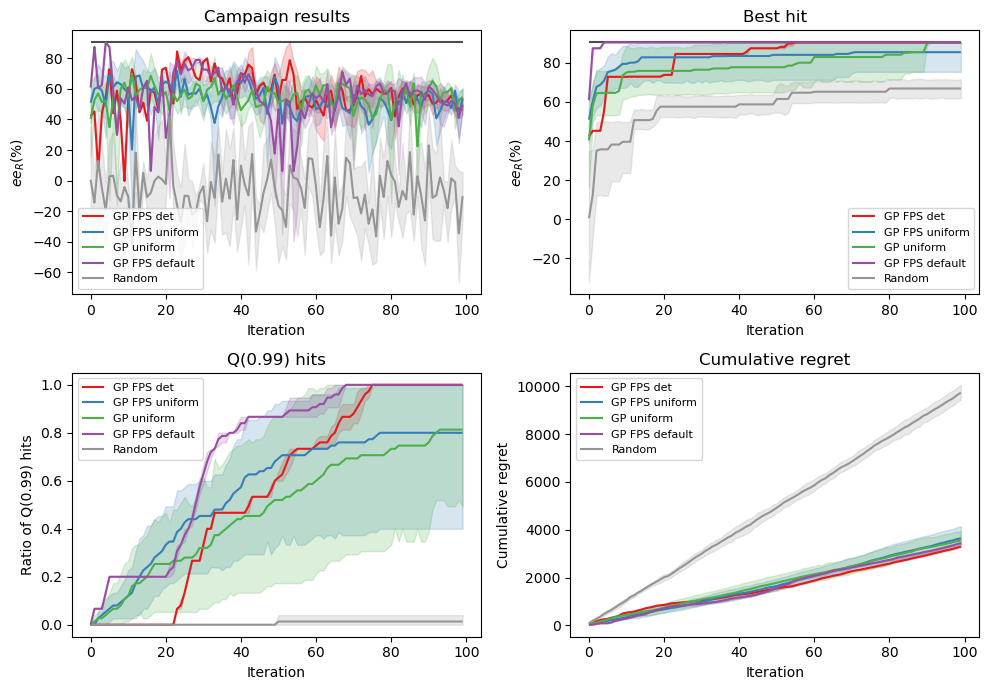

In [12]:
plot_results(results_fp, lookup, figure_name='bo_first_point.png', nbr_controls=1)

Note that here, the graphs are shifted by 10 iterations compared to the previous one because the initialization sequence is not accounted in this plot.

## Surrogates

Finally, different [surrogate models](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.surrogates.html#module-baybe.surrogates) were tried:

[Random forest](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.surrogates.random_forest.RandomForestSurrogate.html#baybe.surrogates.random_forest.RandomForestSurrogate): based on random forest models

[Gaussian process](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.surrogates.gaussian_process.core.GaussianProcessSurrogate.html#baybe.surrogates.gaussian_process.core.GaussianProcessSurrogate): the default of Botorch optimizer

[Bayesian linear](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.surrogates.linear.BayesianLinearSurrogate.html#baybe.surrogates.linear.BayesianLinearSurrogate): performs linear bayesian regression

[NGBoost](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.surrogates.ngboost.NGBoostSurrogate.html#baybe.surrogates.ngboost.NGBoostSurrogate): natural gradient boosted trees

[Mean prediction](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.surrogates.naive.MeanPredictionSurrogate.html#baybe.surrogates.naive.MeanPredictionSurrogate): naive model, returns the mean of the dataset and constant variance (independant of the dataset)

In [13]:
from baybe.surrogates import GaussianProcessSurrogate, RandomForestSurrogate, BayesianLinearSurrogate, NGBoostSurrogate, RandomForestSurrogate, MeanPredictionSurrogate

set_random_seed(11)

#load the surrogate models
surrogates = {
    'Random forest': RandomForestSurrogate(),
    'Gaussian process': GaussianProcessSurrogate(),
    'Bayesian linear': BayesianLinearSurrogate(),
    'NGBoost': NGBoostSurrogate(),
    'Mean prediction': MeanPredictionSurrogate(),
}

def get_recommender(surrogate):
    #return a TwoPhaseMetaRecommender with the given surrogate model
    recommender = TwoPhaseMetaRecommender(
        initial_recommender=FPSRecommender(),                       # farthest point sampling
        recommender=BotorchRecommender(surrogate_model=surrogate),  # Bayesian optimizer
        switch_after=10,                                            # switch to Bayesian optimizer after 10 iterations
        )
    return recommender

recommenders = {key: get_recommender(surrogate) for key, surrogate in surrogates.items()}
recommenders['random'] = RandomRecommender()

campaigns = {
    key: Campaign(searchspace=searchspace, objective=objective, recommender=recommender)
    for key, recommender in recommenders.items()
}

In [ ]:
#simulate the scenarios, takes around 10 minutes on my laptop (11th Gen i7 @ 2.80 GHz, 16GB RAM)

BATCH_SIZE = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5

results = simulate_scenarios(
    campaigns,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

 17%|#6        | 5/30 [01:49<09:07, 21.90s/it]c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\s

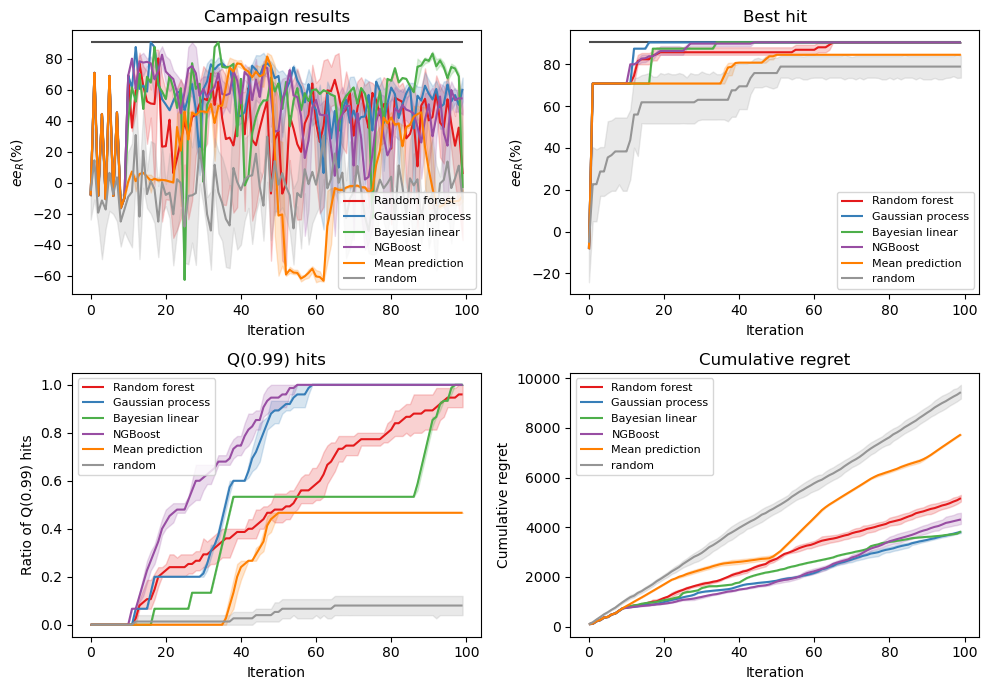

In [15]:
plot_results(results, lookup, figure_name='bo_surrogates.png', nbr_controls=1)